# 导入需要的库

In [1]:
import numpy as np
import functions as f
from gradient import numerical_gradient
from collections import OrderedDict
from layers import *
import pickle
import struct
import matplotlib.pyplot as plt

# 定义读取数据集的函数

In [2]:

def load_mnist_data(kind):
    '''
    加载数据集
    :param kind: 加载训练数据还是测试数据
    :return: 打平之后的数据和one hot编码的标签
    '''
    labels_path = '../data/%s-labels-idx1-ubyte' % kind
    images_path = '../data/%s-images-idx3-ubyte' % kind
    with open(labels_path, 'rb') as lbpath:
        struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)
    with open(images_path, 'rb') as imgpath:
        struct.unpack('>IIII', imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)

    return images / 255., np.eye(10)[labels]

# 定义神经网络架构

In [47]:

class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 初始化权重
        self.params = dict()
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        # 生成层
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        #self.layers['Relu1'] = Relu()
        self.layers['Sigmoid1'] = Sigmoid()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()
        #self.lastLayer = IdentityWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    # x:输入数据, t:监督数据
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    # x:输入数据, t:监督数据
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 设定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

    # 保存权重文件
    def save(self,path):
        with open(path,'wb') as f :
            pickle.dump(self.params, f)

    # 导入权重文件
    def load(self,path):
        with open(path,'rb') as f :
            self.params = pickle.load(f)
            self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
            #self.layers['Relu1'] = Relu()
            self.layers['Sigmoid1'] = Sigmoid()
            self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

    print("Weight has been loaded!")
        #print(weight)



Weight has been loaded!


# 导入训练集和测试集

In [4]:
train_images, train_labels = load_mnist_data(kind='train')
train_images = np.reshape(train_images, newshape=(-1, 1, 784))
test_images, test_labels = load_mnist_data('t10k')
test_images = np.reshape(test_images, newshape=(-1, 1, 784))

In [5]:
training_set_size = len(train_images)
testing_set_size = len(test_images)

In [6]:
## check gradient

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)
mini_batch_size = 100

grad_numerical = network.numerical_gradient(train_images[:mini_batch_size], train_labels[:mini_batch_size])
grad_backprop = network.gradient(train_images[:mini_batch_size], train_labels[:mini_batch_size])


for key in grad_numerical.keys():
    diff = np.average( np.abs(grad_backprop[key] - grad_numerical[key]) )
    print(key + ":" + str(diff))

W1:6.845633989410145e-11
b1:2.0751083676095328e-10
W2:1.1809442230326356e-08
b2:2.3594813608994458e-08


In [57]:
network = TwoLayerNet(input_size=784, hidden_size=128, output_size=10, weight_init_std = 4*np.sqrt(2.0 / (1+50)))
weight_save_path  = "weight.pickle"
iters_num = 100000  # 适当设定循环的次数
train_size = train_images.shape[0]
batch_size = 128
learning_rate = 1e-2
train_loss_list = []
test_loss_list = []
iter_per_epoch = max(train_size / batch_size, 1)
iter_num = 10
load_weight = True
train_net = True
if load_weight:
    network.load(weight_save_path)
if True:
    accuracy = np.sum(network.predict(test_images).argmax(1) == test_labels.argmax(1))/testing_set_size
    print(f"epoch: , train loss, test loss , accuracy |, {accuracy*100}%")
    print("Weight has been saved !!")
if train_net:
    for i in range(iters_num):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = train_images[batch_mask]
        y_batch = train_labels[batch_mask]

        # 计算梯度
        #grad = network.numerical_gradient(x_batch, y_batch)
        grad = network.gradient(x_batch, y_batch)
        # 更新参数
        for key in ('W1', 'b1', 'W2', 'b2'):
            network.params[key] -= learning_rate * grad[key]

        loss = network.loss(x_batch, y_batch)
        train_loss_list.append(loss)
        loss_test = network.loss(test_images, test_labels)
        accuracy = np.sum(network.predict(test_images).argmax(1) == test_labels.argmax(1))/testing_set_size
        test_loss_list.append(loss_test)

        #if i % iter_per_epoch == 0:
        if i % iter_num == 0:
            print(f"epoch: {i}, train loss, test loss , accuracy |{loss} , {loss_test}, {accuracy*100}%")
            network.save(weight_save_path)
            print("Weight has been saved !!")

epoch: , train loss, test loss , accuracy |, 89.27000000000001%
Weight has been saved !!
epoch: 0, train loss, test loss , accuracy |0.40286418417175096 , 0.34811251459967296, 89.27000000000001%
Weight has been saved !!
epoch: 10, train loss, test loss , accuracy |0.44070368358283313 , 0.348072451859691, 89.3%
Weight has been saved !!
epoch: 20, train loss, test loss , accuracy |0.33559524374910044 , 0.34806169142657156, 89.32%
Weight has been saved !!
epoch: 30, train loss, test loss , accuracy |0.29523937996132893 , 0.34803249762450295, 89.3%
Weight has been saved !!
epoch: 40, train loss, test loss , accuracy |0.32109155136334055 , 0.34801913514205507, 89.31%
Weight has been saved !!
epoch: 50, train loss, test loss , accuracy |0.3407923984896475 , 0.3480404596678307, 89.32%
Weight has been saved !!
epoch: 60, train loss, test loss , accuracy |0.41342615680491757 , 0.3480256870555344, 89.3%
Weight has been saved !!
epoch: 70, train loss, test loss , accuracy |0.3065611310577806 , 0.

KeyboardInterrupt: 

E:\桌面\深度学习数学基础\DeepLearning-Basics\MLP\Solution Given by teacher\functions.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


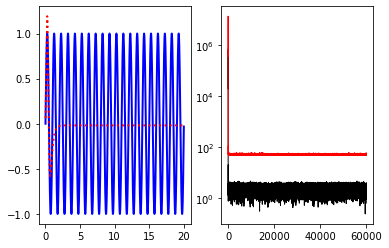

In [15]:
# 绘制图形
x_test =  np.arange(0, 20, 0.005).reshape(-1,1)
y_test = object_fun(x_test)
y_predict = network.predict(x_test)

fig,axs = plt.subplots(1,2)
axs = axs.reshape(-1)

axs[0].plot(x_test,y_test,'b',linewidth=2)
axs[0].plot(x_test,y_predict,':r',linewidth=2)

axs[1].semilogy(train_loss_list,color='k',linewidth=1)
axs[1].semilogy(test_loss_list,color='r',linewidth=1)

plt.show()